In [28]:
%reload_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils

folder_path = "jatos_results_20240125"
metadata_path = "jatos_results_20240125/metadata.json"

mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [29]:
%run -i lib\load_data

Save meta data as meta_data.csv
Main data loaded successfully.
Number of participants who fail consistency check: 40
Worker IDs to be excluded: ['434924', '434925', '434933', '434938', '434939', '434948', '434950', '434951', '434956', '434965', '434970', '434973', '434975', '434987', '434991', '434994', '435006', '435007', '435012', '435014', '435023', '435025', '435034', '435037', '435044', '435050', '435051', '435061', '435071', '435078', '435082', '435085', '435088', '435091', '435094', '435102', '435109', '435112', '435125', '435126']
Consistency check finished.
Number of participants in each cluster: [ 54 103]


In [30]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

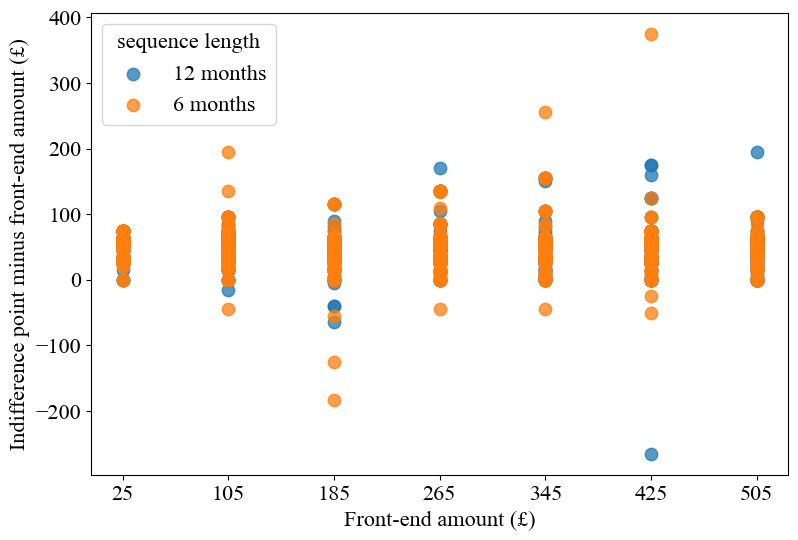

In [31]:
# Plot: check outliers
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
seq_length_list = df_plot['seq_length'].unique()
front_amount_list = df_plot['front_amount'].unique()

plt.figure(figsize=(9, 6))
for t in seq_length_list:
    tab_plot = df[df['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['value_surplus'],label=t,alpha=0.75,s=80)

# Add title and labels
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')
plt.xticks(front_amount_list)
plt.legend(loc=2,title='sequence length')
plt.show()

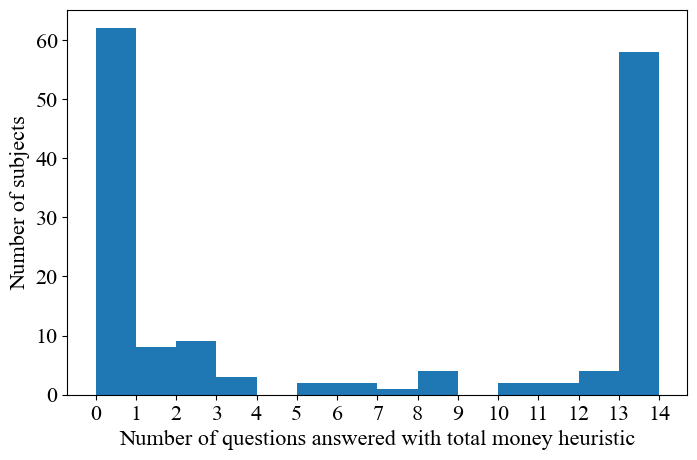

In [33]:
df['total_money_heuristic'] = df['value_surplus'] == 60
plt.figure(figsize=(8,5))
plt.hist(df.groupby('worker_id')['total_money_heuristic'].sum(),bins=14)
plt.xticks(np.arange(15))
plt.ylabel('Number of subjects')
plt.xlabel('Number of questions answered with total money heuristic')
plt.show()

Text(0.5, 0, 'front-end amount (£)')

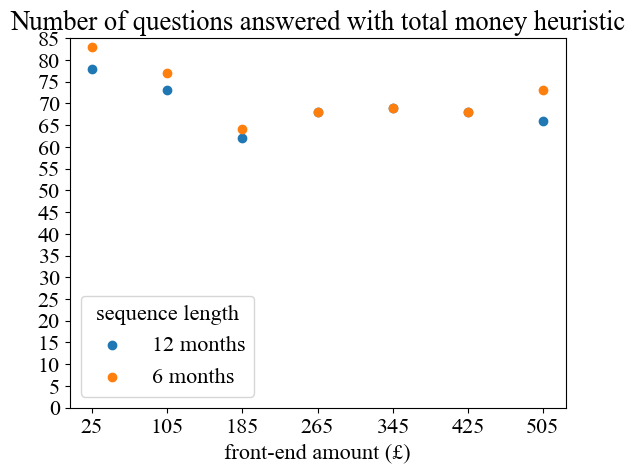

In [63]:
df_plot = df.groupby(['seq_length','front_amount'])['total_money_heuristic'].sum().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['total_money_heuristic'],label=t)

plt.title('Number of questions answered with total money heuristic')
plt.legend(loc='best',title='sequence length')
plt.xticks(front_amount_list)
plt.yticks(np.arange(0,90,step=5))
plt.xlabel('front-end amount (£)')

Text(0.5, 0, 'front-end amount (£)')

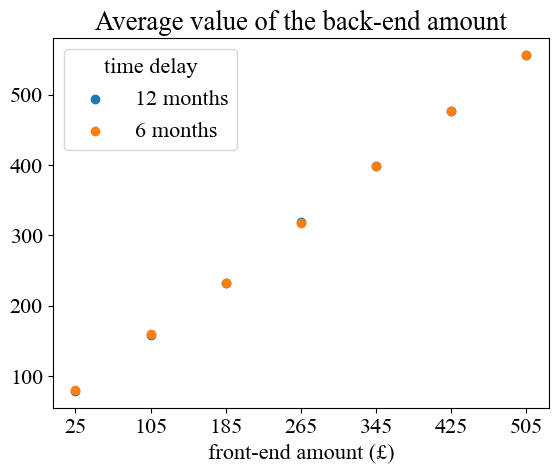

In [65]:
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['indiff_point'],label=t)

plt.title('Average value of the back-end amount')
plt.legend(loc='best',title='time delay')
plt.xticks(front_amount_list)
plt.xlabel('front-end amount (£)')

In [34]:
# If data is clustered to three groups, one of these groups only has 9 subjects  
df_time_pivot_2 = df.pivot(index='worker_id', columns='reward', values='value_surplus')
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(df_time_pivot_2.values)
print('Number of participants in each cluster:',np.bincount(kmeans.labels_))

Number of participants in each cluster: [ 43   9 105]


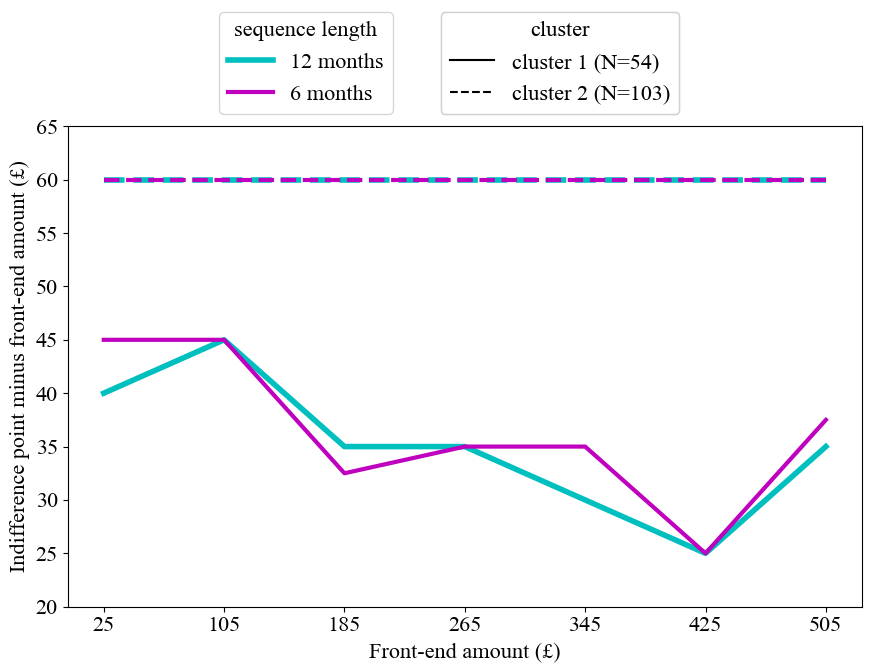

In [35]:
df_plot_median = df.groupby(['seq_length','front_amount','label'])['value_surplus'].median().to_frame().reset_index()

color_list = ['c','m']
linewidth_list = [4,3]

fig,ax  = plt.subplots(2, 1, figsize=(9, 7), gridspec_kw={'height_ratios': [0.15, 0.85]})

for t in range(len(seq_length_list)):
        tab_plot_0 = df_plot_median[(df_plot_median['seq_length'] == seq_length_list[t]) & (df_plot_median['label'] == 0)]
        tab_plot_1 = df_plot_median[(df_plot_median['seq_length'] == seq_length_list[t]) & (df_plot_median['label'] == 1)]
        ax[1].plot(tab_plot_0['front_amount'],tab_plot_0['value_surplus'],ls='solid',c=color_list[t],lw=linewidth_list[t])
        ax[1].plot(tab_plot_1['front_amount'],tab_plot_1['value_surplus'],ls='dashed',c=color_list[t],lw=linewidth_list[t])

ax[1].plot(np.NaN,np.NaN,ls='solid',c='black')
ax[1].plot(np.NaN,np.NaN,ls='dashed',c='black')


plt.yticks(np.arange(20,70,step=5))
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')


lines = ax[1].get_lines()
legend1 = plt.legend([lines[i] for i in [0,2]], ["12 months", "6 months"], title='sequence length',
                     loc='upper center', bbox_to_anchor=(0.3, 1.26))
legend2 = plt.legend([lines[i] for i in [4,5]], ["cluster 1 (N=54)", "cluster 2 (N=103)"], title='cluster',
                     loc='upper center', bbox_to_anchor=(0.62, 1.26))
ax[1].add_artist(legend1)
ax[1].add_artist(legend2)

ax[0].axis('off')
plt.tight_layout()
plt.xticks(front_amount_list)
plt.show()


In [36]:
print('Response time for',df.groupby('total_money_heuristic')['response_time_enter'].mean())
print(stats.ttest_ind(df['response_time_enter'][df['total_money_heuristic'] == 0],
                df['response_time_enter'][df['total_money_heuristic'] == 1]))

print('Ratio of answers using total_money_heuristic for',df.groupby('label')['total_money_heuristic'].mean())
print(stats.ttest_ind(df['total_money_heuristic'][df['label'] == 0],
                df['total_money_heuristic'][df['label'] == 1]))

Response time for total_money_heuristic
False    10899.804455
True      9282.460446
Name: response_time_enter, dtype: float64
TtestResult(statistic=4.169277943917821, pvalue=3.174277835455027e-05, df=2196.0)
Ratio of answers using total_money_heuristic for label
0    0.088624
1    0.637309
Name: total_money_heuristic, dtype: float64
TtestResult(statistic=-28.834621406270777, pvalue=2.5308112696544666e-155, df=2196.0)


In [37]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label'] == 0]['value_surplus'],
                df[df['label'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label'] == 1]['value_surplus'],
                    df[df['label'] == 1]['front_amount']))

SignificanceResult(statistic=-0.043245998593847375, pvalue=0.04263276342226129)
SignificanceResult(statistic=-0.17557494143900643, pvalue=1.189944758721708e-06)
SignificanceResult(statistic=-0.016437572770570754, pvalue=0.5328273275241426)


In [47]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_value']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_value']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]

y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_baseline]).astype(float)

model_ols_pool_1 = sm.OLS(endog = y , exog = X).fit()
# model_ols_pool_1.summary()

Number of outliers (lower and upper): [4, 8]


In [48]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_label]).astype(float)
model_ols_pool_2 = sm.OLS(endog = y , exog = X).fit()
# model_ols_pool_2.summary()

In [51]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=300)
# model_rlm_pool_1.summary()

In [52]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=300)
# model_rlm_pool_2.summary()

In [53]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_dummy]).astype(float)
model_ols_fe = sm.OLS(endog = y , exog = X).fit()
# model_ols_fe.summary()

In [ ]:
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_dummy_2]).astype(float)

model_ols_fe_2 = sm.OLS(endog = y , exog = X).fit()
# model_ols_fe_2.summary()

In [54]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=300)
# model_rlm_fe.summary()

In [57]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)

model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=300)
model_rlm_fe_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          value_surplus   No. Observations:                 2198
Model:                            RLM   Df Residuals:                     2037
Method:                          IRLS   Df Model:                          160
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 01 Feb 2024                                         
Time:                        22:26:15                                         
No. Iterations:                   135                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 51.9505      0.133    390.890      0.000      51.690      52.211
front_amount_6m_0     -0.0142      0.001    -22.906      0.000      -0.015      -0.013
front_amount_12m_0    -0.0188      0.001    -30.377      0.000      -0.020      -0.018
front_amount_6m_1     -0.0002      0.000     -0.545      0.586      -0.001       0.001
front_amount_12m_1    -0.0004      0.000     -0.842      0.400      -0.001       0.001
choice_value           2.3327      0.117     19.886      0.000       2.103       2.563
worker_id_434923       5.9374      0.648      9.165      0.000       4.668       7.207
worker_id_434926       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434927      10.7994      0.648     16.669      0.000       9.530      12.069
worker_id_434928     -22.8053      0.649    -35.131      0.000     -24.078     -21.533
worker_id_434930       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434931       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434932      58.6745      0.648     90.566      0.000      57.405      59.944
worker_id_434934      -1.7906      0.648     -2.764      0.006      -3.060      -0.521
worker_id_434935      -4.8888      0.656     -7.457      0.000      -6.174      -3.604
worker_id_434936     -20.4918      0.656    -31.255      0.000     -21.777     -19.207
worker_id_434937     -48.9255      0.649    -75.368      0.000     -50.198     -47.653
worker_id_434940       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434941       8.2724      0.641     12.900      0.000       7.016       9.529
worker_id_434942     -11.2275      0.656    -17.125      0.000     -12.513      -9.943
worker_id_434943      15.8438      0.648     24.455      0.000      14.574      17.114
worker_id_434944       7.9959      0.641     12.469      0.000       6.739       9.253
worker_id_434945       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434946     -12.3321      0.656    -18.810      0.000     -13.617     -11.047
worker_id_434947       8.1320      0.641     12.682      0.000       6.875       9.389
worker_id_434949     -11.2858      0.656    -17.214      0.000     -12.571     -10.001
worker_id_434952       8.2677      0.641     12.893      0.000       7.011       9.525
worker_id_434953      10.5418      0.656     16.079      0.000       9.257      11.827
worker_id_434954       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434955       8.1320      0.641     12.682      0.000       6.875       9.389
worker_id_434957      -0.1309      0.648     -0.202      0.840      -1.401       1.139
worker_id_434958       5.7994      0.648      8.952      0.000       4.530       7.069
worker_id_434959       1.0417      0.6

NormaltestResult(statistic=1514.0493854155256, pvalue=0.0)


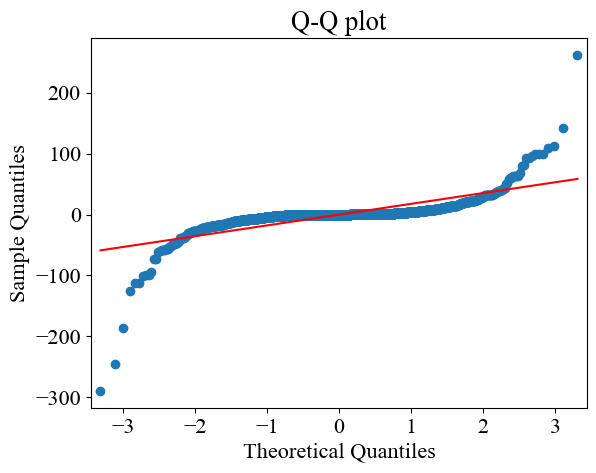

In [68]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [67]:
# save regression results
model_results = {'ols_pool_baseline':utils.get_reg_result(model_ols_pool_1,reg_cols_baseline),
                 'ols_pool_label':utils.get_reg_result(model_ols_pool_2,reg_cols_baseline),
                 'ols_fe_baseline':utils.get_reg_result(model_ols_fe,reg_cols_baseline),
                 'ols_fe_label':utils.get_reg_result(model_ols_fe_2,reg_cols_label),
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result.json', "w") as f:
    json.dump(model_results, f)

In [69]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=5,fe=True)
bootstrap_fit = model_bootstrap.bootstrap()

100%|██████████| 5/5 [00:13<00:00,  2.66s/it]
